Scratch file for figuring out how to do PCA of AmpTools covariance matrix (thats been converted into a csv file) and comparing that to bootstrap PCA. Next step is understanding how correlations tie into PCA

In [1]:
import pandas as pd
import sklearn
import sklearn.preprocessing
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import seaborn as sns

from pathlib import Path    
import sys, os
parent_dir = str(Path().resolve().parents[1])
sys.path.insert(0, parent_dir)
import analysis.scripts.pwa_tools as pwa_tools

# change some plot parameters to look better
plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["figure.dpi"] = 500 # TEMP: reduced for file size. Can increase for presentations
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["legend.fontsize"] = 16
plt.rcParams["xtick.major.width"] = 2.0
plt.rcParams["xtick.minor.width"] = 1.8
plt.rcParams["ytick.major.width"] = 2.0
plt.rcParams["ytick.minor.width"] = 1.8
plt.rcParams["lines.markersize"] = 10 # bumped down from normal due to large mass range

Now read in the bootstrap matrix for that same bin

### Bootstrap PCA

In [2]:
# read in bootstrap matrix for bin df to compare to MINUIT PCA
df_bootstrap = pd.read_csv(f"{parent_dir}/analysis/input-output-tests/0m_1m_1p/bootstrap-fits_t_0.30-0.50.csv")
df_bootstrap = df_bootstrap[df_bootstrap["bin_range"]=="1.200-1.220"]

In [3]:
# copied primarily from here https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis/50845697#50845697

from sklearn.decomposition import PCA

features = [x for x in df_bootstrap.columns if ("re" in x or "im" in x) and "err" not in x]
print(f"Number of original features: {len(features)}")
x = df_bootstrap.loc[:, features].values

# standardize onto unit scale (mean=0, variance=1)
x = sklearn.preprocessing.StandardScaler().fit_transform(x)
pca = PCA(0.95) # keep enough principle components to have 95% variance explained
principal_components = pca.fit_transform(x)
n_components = pca.components_.shape[0]
print(pca.explained_variance_)
print(f"number of principal components: {n_components}")

# determine most important feature of each PCA and save to a dict and dataframe
important_index = [np.abs(component).argmax() for component in pca.components_]
important_names = [features[index] for index in important_index]
dic = {f"PC{i}" : important_names[i] for i in range(n_components)}
pca_df = pd.DataFrame(dic.items())

# count number of times each particular feature is the most important for the PCAs
from collections import Counter
counted_items = Counter(dic.values())
counted_items = {k : v for k,v in sorted(counted_items.items(), key=lambda item: item[1])} # sort by value

for key, val in counted_items.items():
    print(f"{key} : {val}")

Number of original features: 40
[8.86721395 6.19622576 3.20178371 2.92006656 2.48557393 1.94765129
 1.66658845 1.45819393 1.18603137 0.99581385 0.91406237 0.78735244
 0.69245128 0.56565617 0.52911632 0.44905226 0.40606857 0.35869939
 0.33657429 0.30940866 0.26043546]
number of principal components: 21
p1ppD_im : 1
p1ppS_re : 1
m1pmD_im : 1
m1pmS_re : 1
p1m0P_im : 1
m1mpP_re : 1
m1ppD_re : 1
m1p0S_im : 1
m0m0P_im : 1
m1ppS_im : 1
p1pmD_re : 1
p1pmS_re : 2
m1p0S_re : 2
p1mmP_re : 2
p1mmP_im : 2
p1mpP_re : 2


### MINUIT PCA

In [5]:
# read in the dataframe, and remove parameters who are not related to amplitudes, and the background params
df = pd.read_csv(f"{parent_dir}/analysis/other_notebooks/covariance.csv", index_col="parameters")
df = df.loc[df.index.str.contains("::") & ~df.index.str.contains("Bkgd"), 
            df.columns.str.contains("::") & ~df.index.str.contains("Bkgd")]

In [6]:
matrix = df.to_numpy()
print(f"Number of original features: {matrix.shape[0]}")

eigenvalues, eigenvectors = np.linalg.eig(matrix)

order = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[order]
sorted_eigenvectors = eigenvectors[:, order]

explained_variance = sorted_eigenvalues / np.sum(sorted_eigenvalues)

total = 0.0
for i, var in enumerate(explained_variance):
    total += var
    if total > 0.95:
        break
print(f"Number of principal components: {i+1}")

# need to relate this in the same way as the bootstrap, counting the # of maximally contributing features


Number of original features: 40
Number of principal components: 16


### Discussion
One of the big reasons for why the number of principal components can vary between each method is due to the standardization. The bootstrap dataframes are normalized so that they have a mean of 0 and variance of 1 in each feature (column). This is recommended by just about every tutorial out there. 

Even when data is all on the same unit scale it seems recommended, but a clear argument doest not seem to form why

## Attempts on bootstrap data
Now that we have a sense of how PCA works, lets try it on some variables where we might be expecting linear dependencies to show up: the magnitudes and phase differences of the amplitudes

In [7]:
from sklearn.decomposition import PCA

coh_sums = pwa_tools.get_coherent_sums(df_bootstrap)
phase_diffs = pwa_tools.get_phase_differences(df_bootstrap)

features = [x for x in df_bootstrap.columns if x in coh_sums["eJPmL"] or x in set(phase_diffs.values())]

print(f"Number of original features: {len(features)}")
x = df_bootstrap.loc[:, features].values

# standardize onto unit scale (mean=0, variance=1)
x = sklearn.preprocessing.StandardScaler().fit_transform(x)
pca = PCA(0.95) # keep enough principle components to have 95% variance explained
principal_components = pca.fit_transform(x)
n_components = pca.components_.shape[0]
print(f"number of principal components: {n_components}")
print(pca.explained_variance_ratio_)




Number of original features: 110
number of principal components: 22
[0.15622278 0.108485   0.08707389 0.08144865 0.07767097 0.05618629
 0.05188868 0.04853493 0.04289383 0.04000361 0.03557312 0.02790433
 0.02221671 0.0200288  0.01873022 0.01751327 0.01559921 0.01345375
 0.01059134 0.00880486 0.00763457 0.00733669]


We can make some dataframes to see what the important features are for each principal component

In [8]:
# determine most important feature of each PCA and save to a dict and dataframe
important_index = [np.abs(component).argmax() for component in pca.components_]
important_names = [features[index] for index in important_index]
dic = {f"PC{i}" : important_names[i] for i in range(n_components)}
pca_important_df = pd.DataFrame(dic.items())

# count number of times each particular feature is the most important for the PCAs
from collections import Counter
counted_items = Counter(dic.values())
counted_items = {k : v for k,v in sorted(counted_items.items(), key=lambda item: item[1])} # sort by value

for key, val in counted_items.items():
    print(f"{key} : {val}")

p1p0S_p1ppD : 1
p1p0D_p1mpP : 1
m1ppD_m1mmP : 1
p1pmD_p1ppS : 1
m1p0S_m1mpP : 1
m0m0P_m1p0S : 1
p0m0P_p1pmD : 1
p0m0P_p1ppS : 1
m1p0D_m1m0P : 1
m1p0D_m1ppS : 1
p1p0S_p1p0D : 1
m0m0P_m1pmS : 1
p1pmD_p1m0P : 1
p1p0S : 1
m1pmS_m1m0P : 1
m1pmD_m1mmP : 1
p1p0D : 1
p1mmP : 1
m1mpP : 1
m1ppS : 1
m1pmS : 1
m1mmP : 1


Lets now take a look at some biplots for the top 5 components, which capture 50% of the variance. All plots will be between a PC and PC0

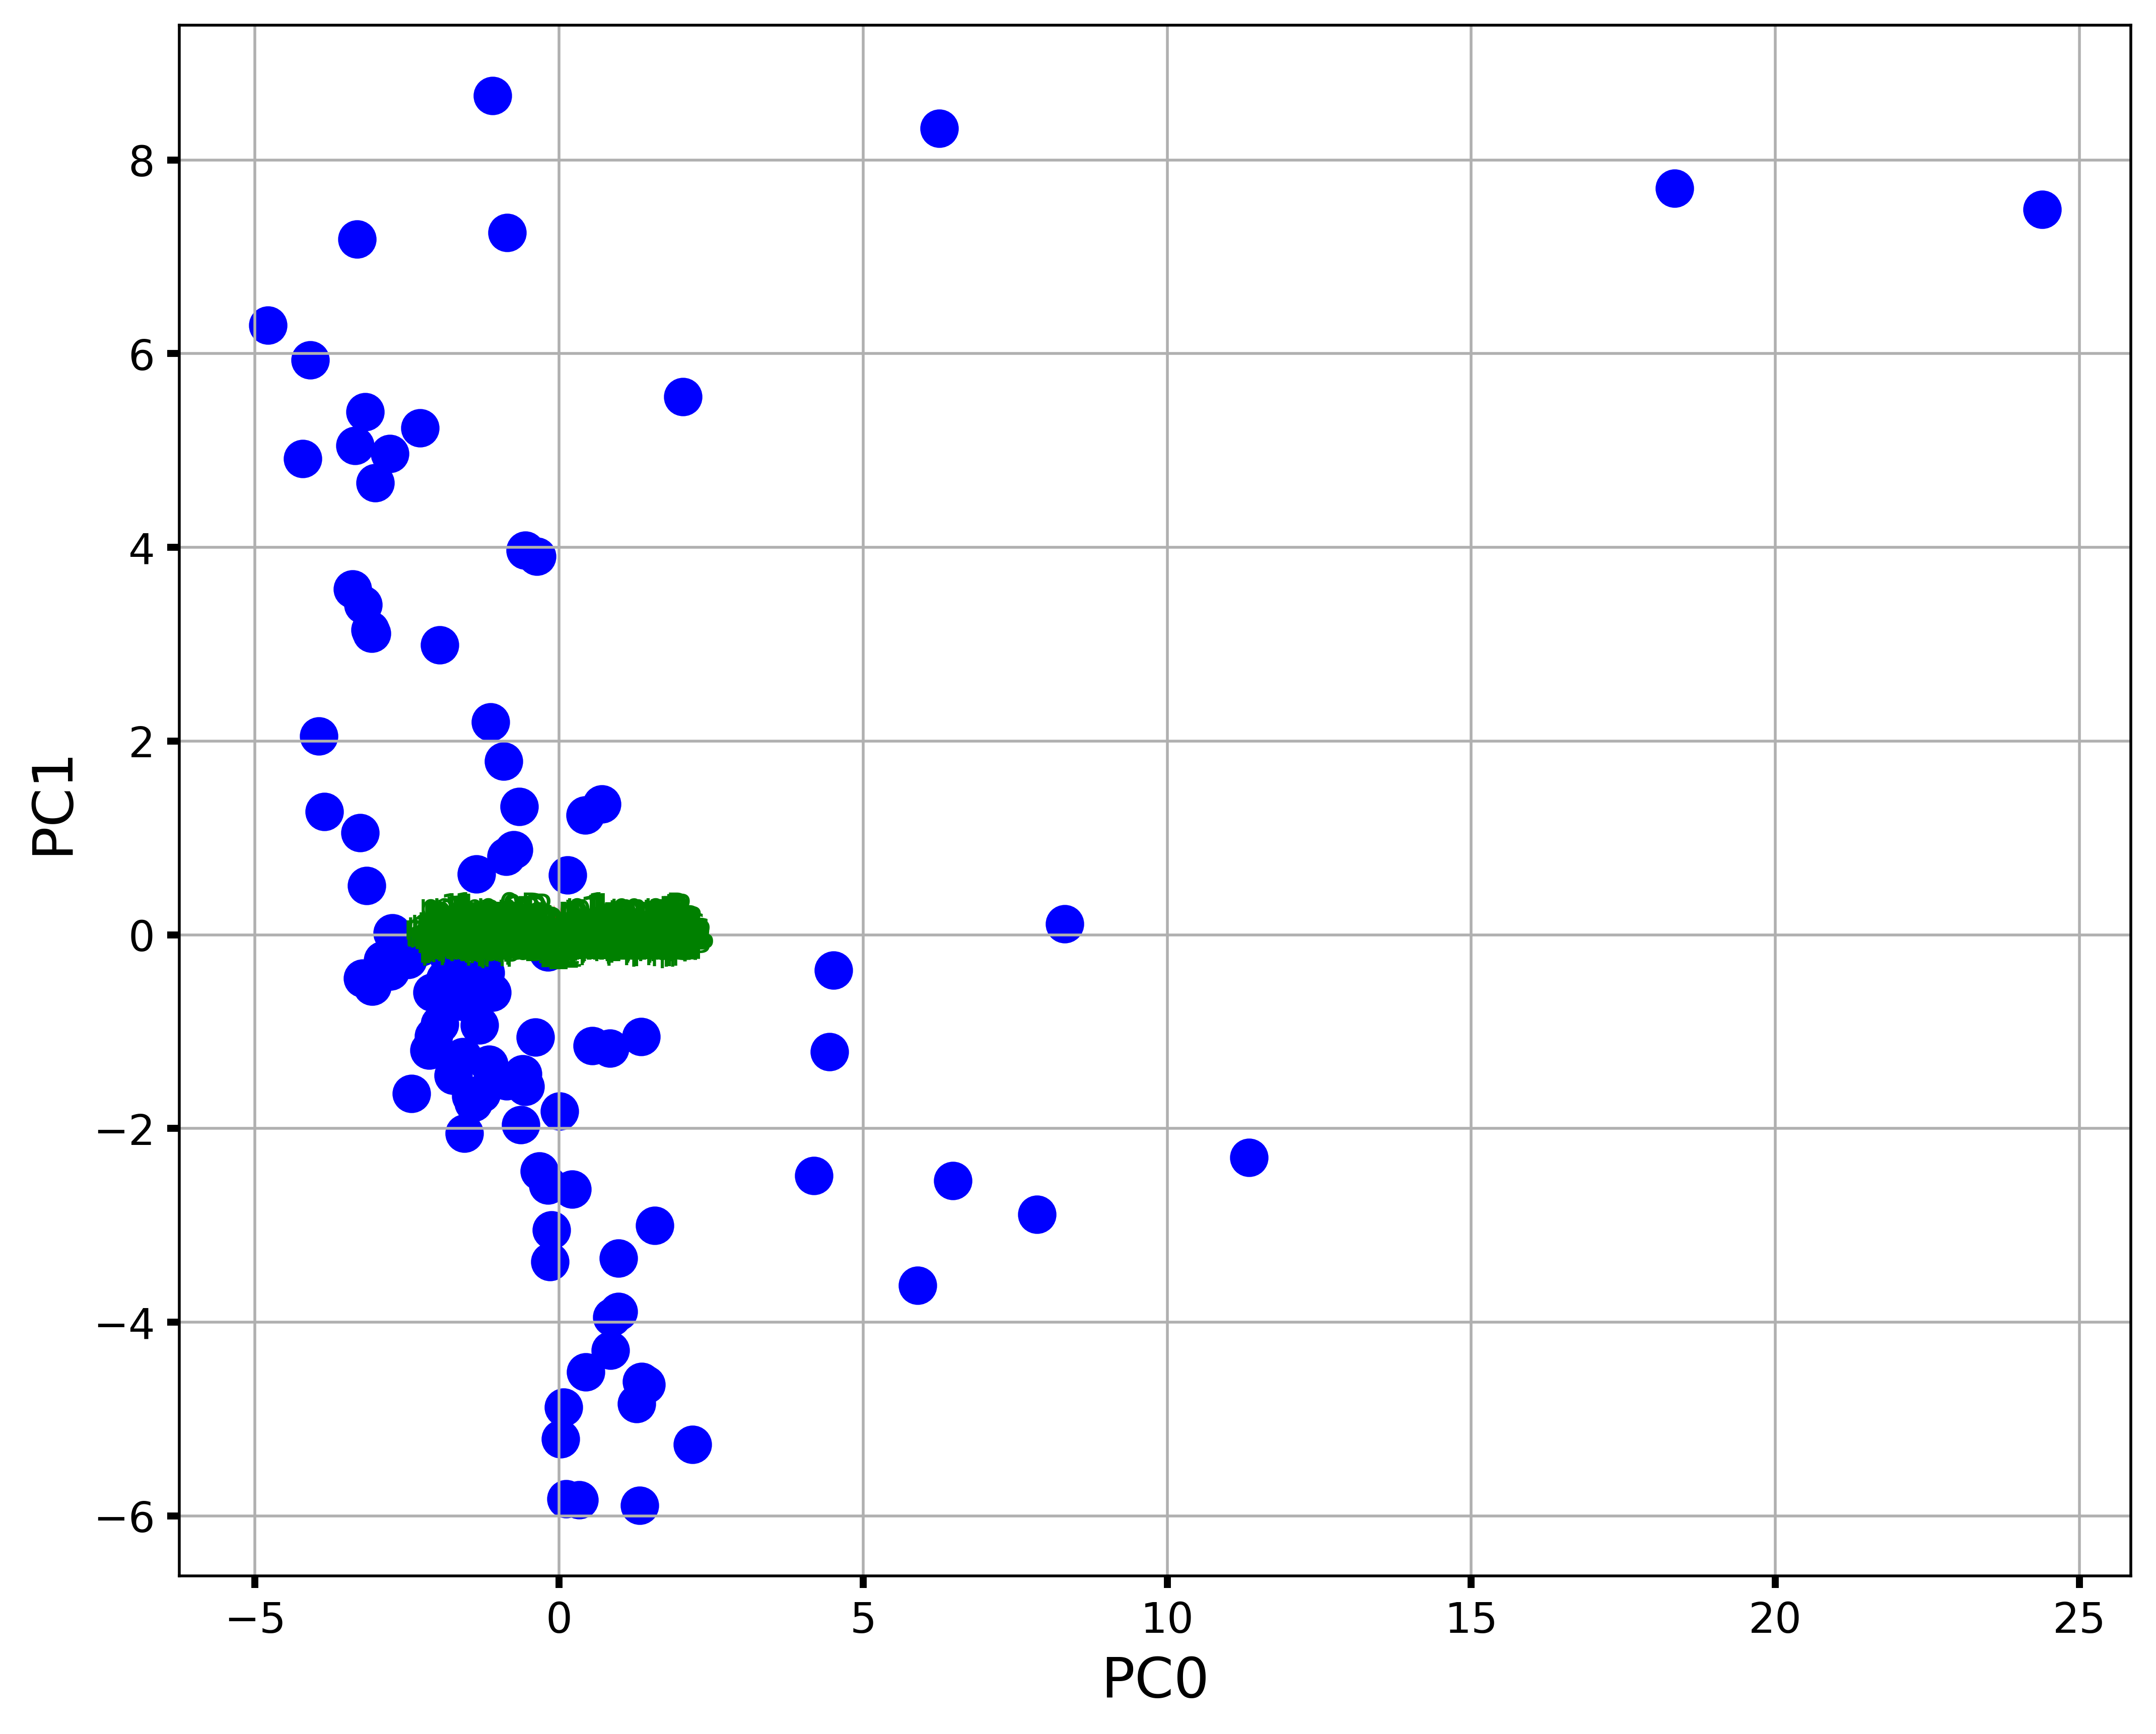

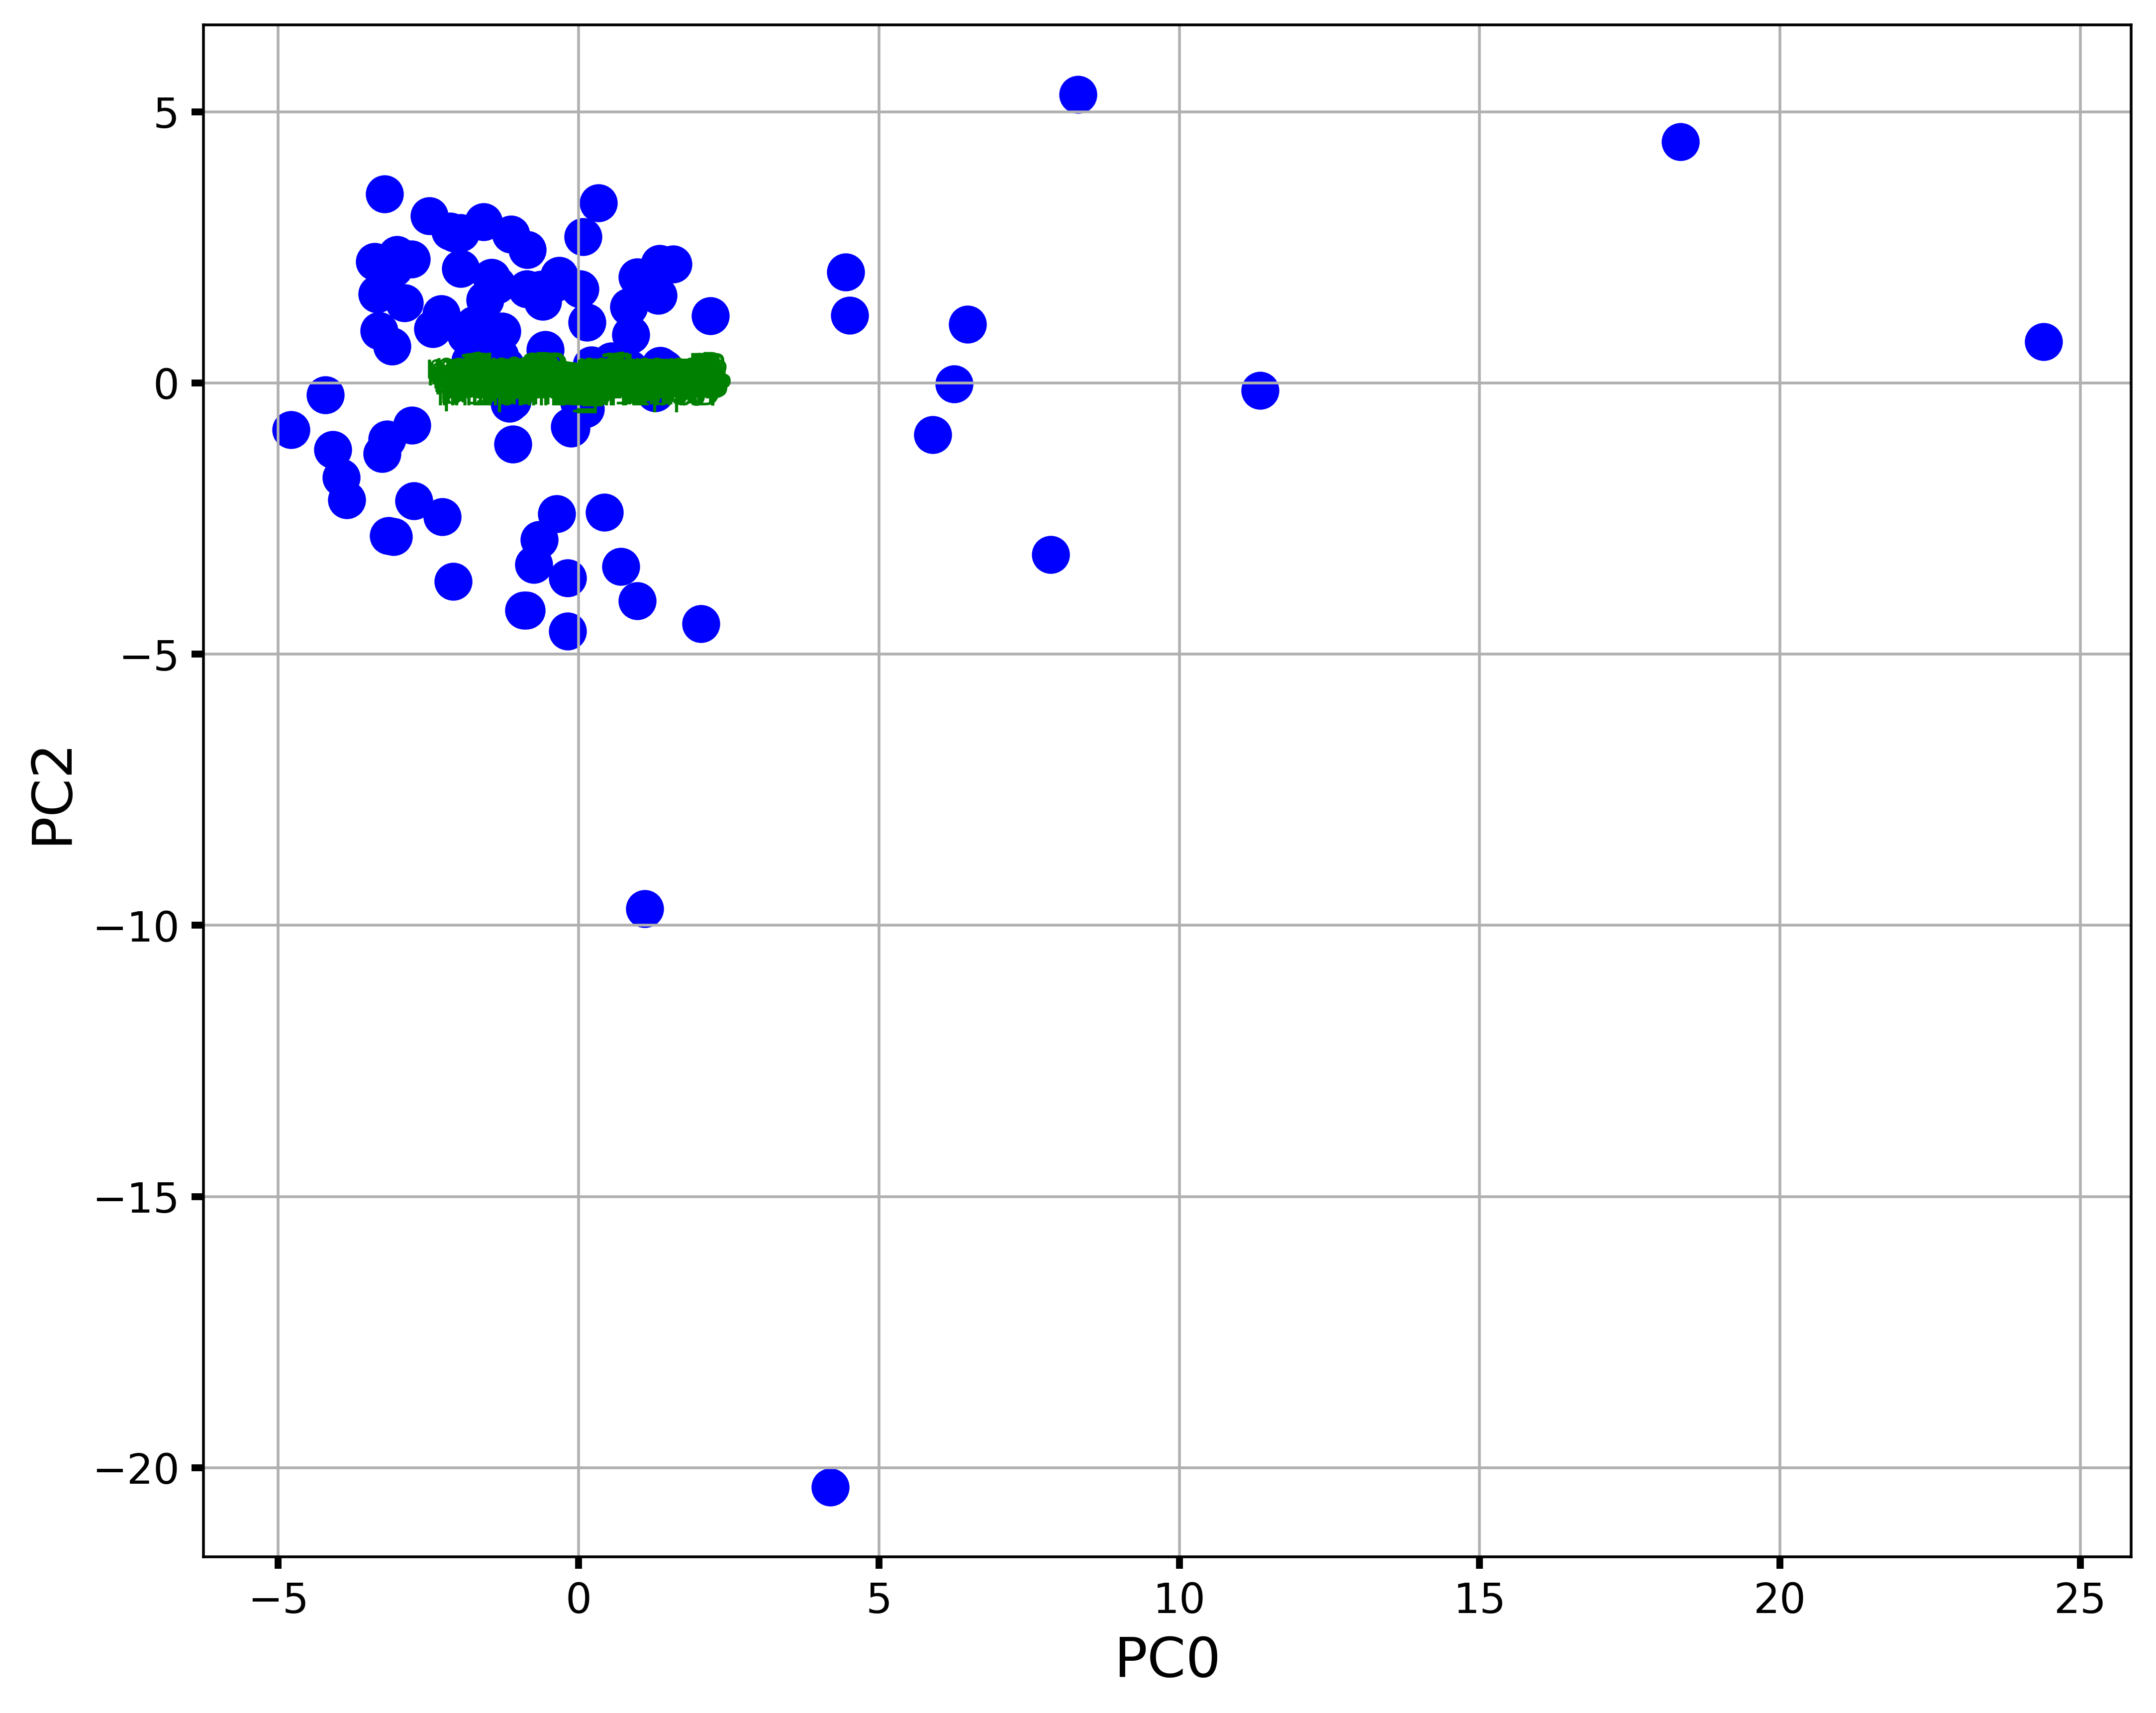

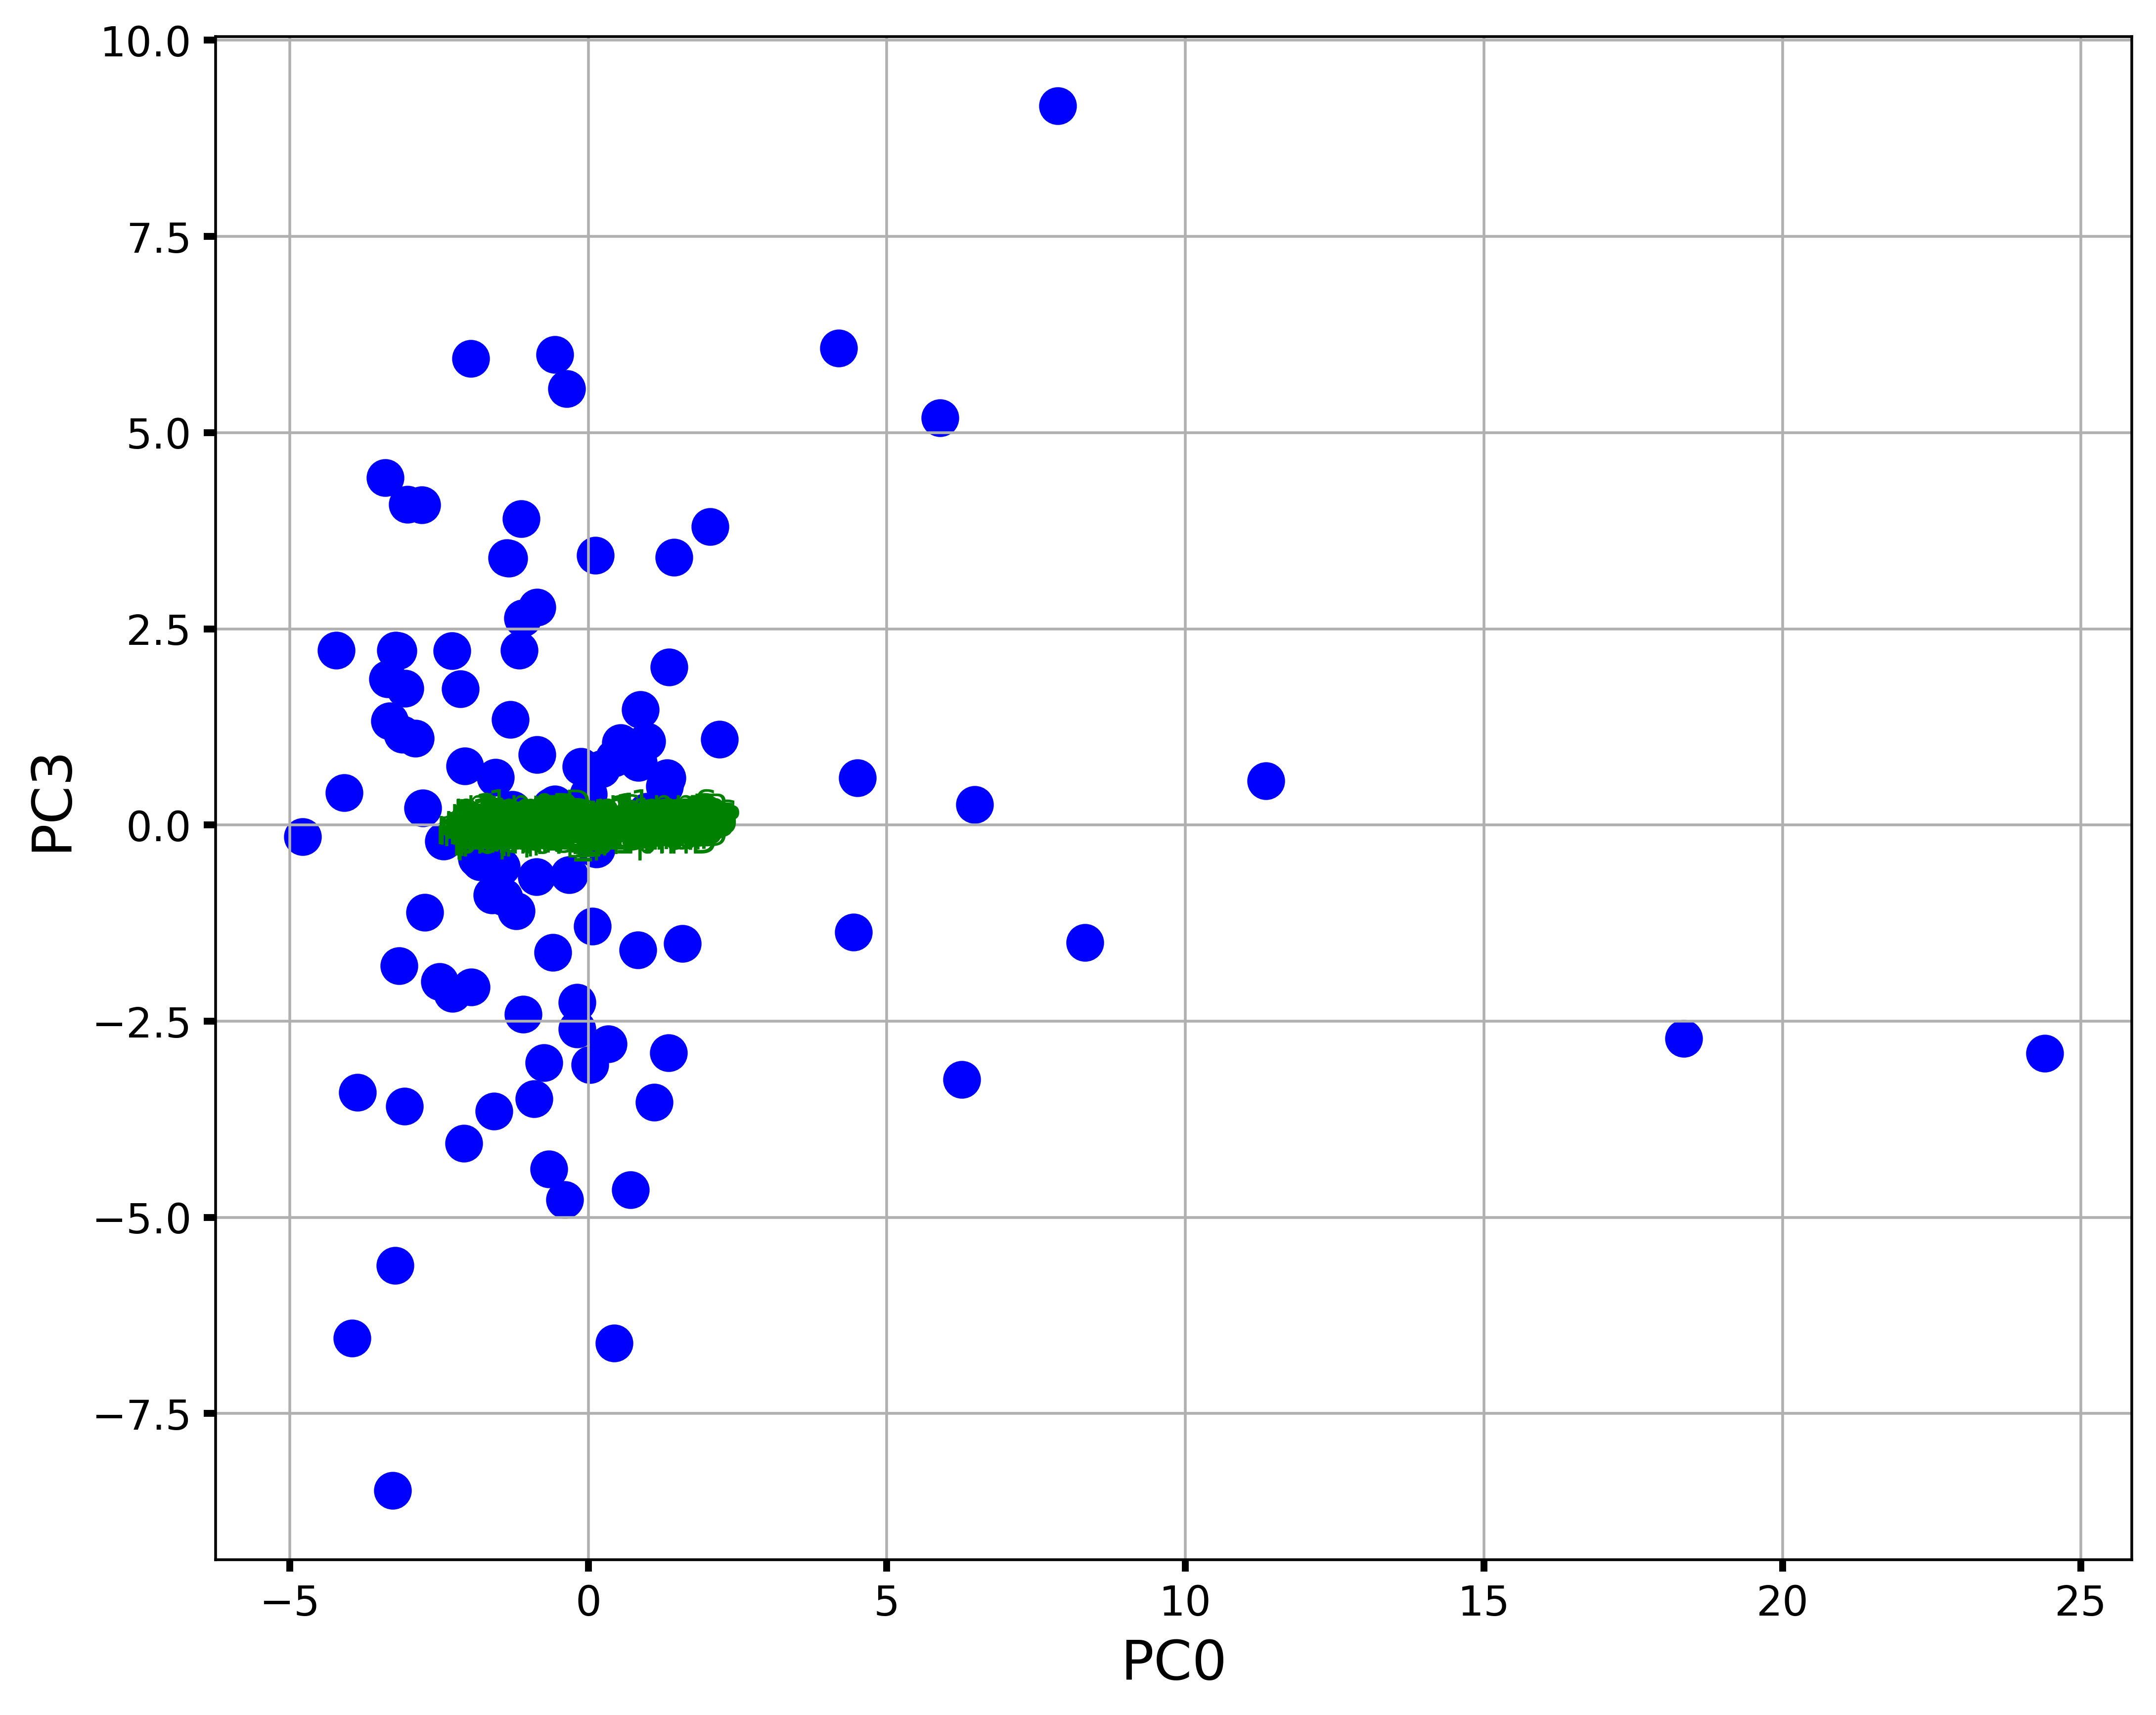

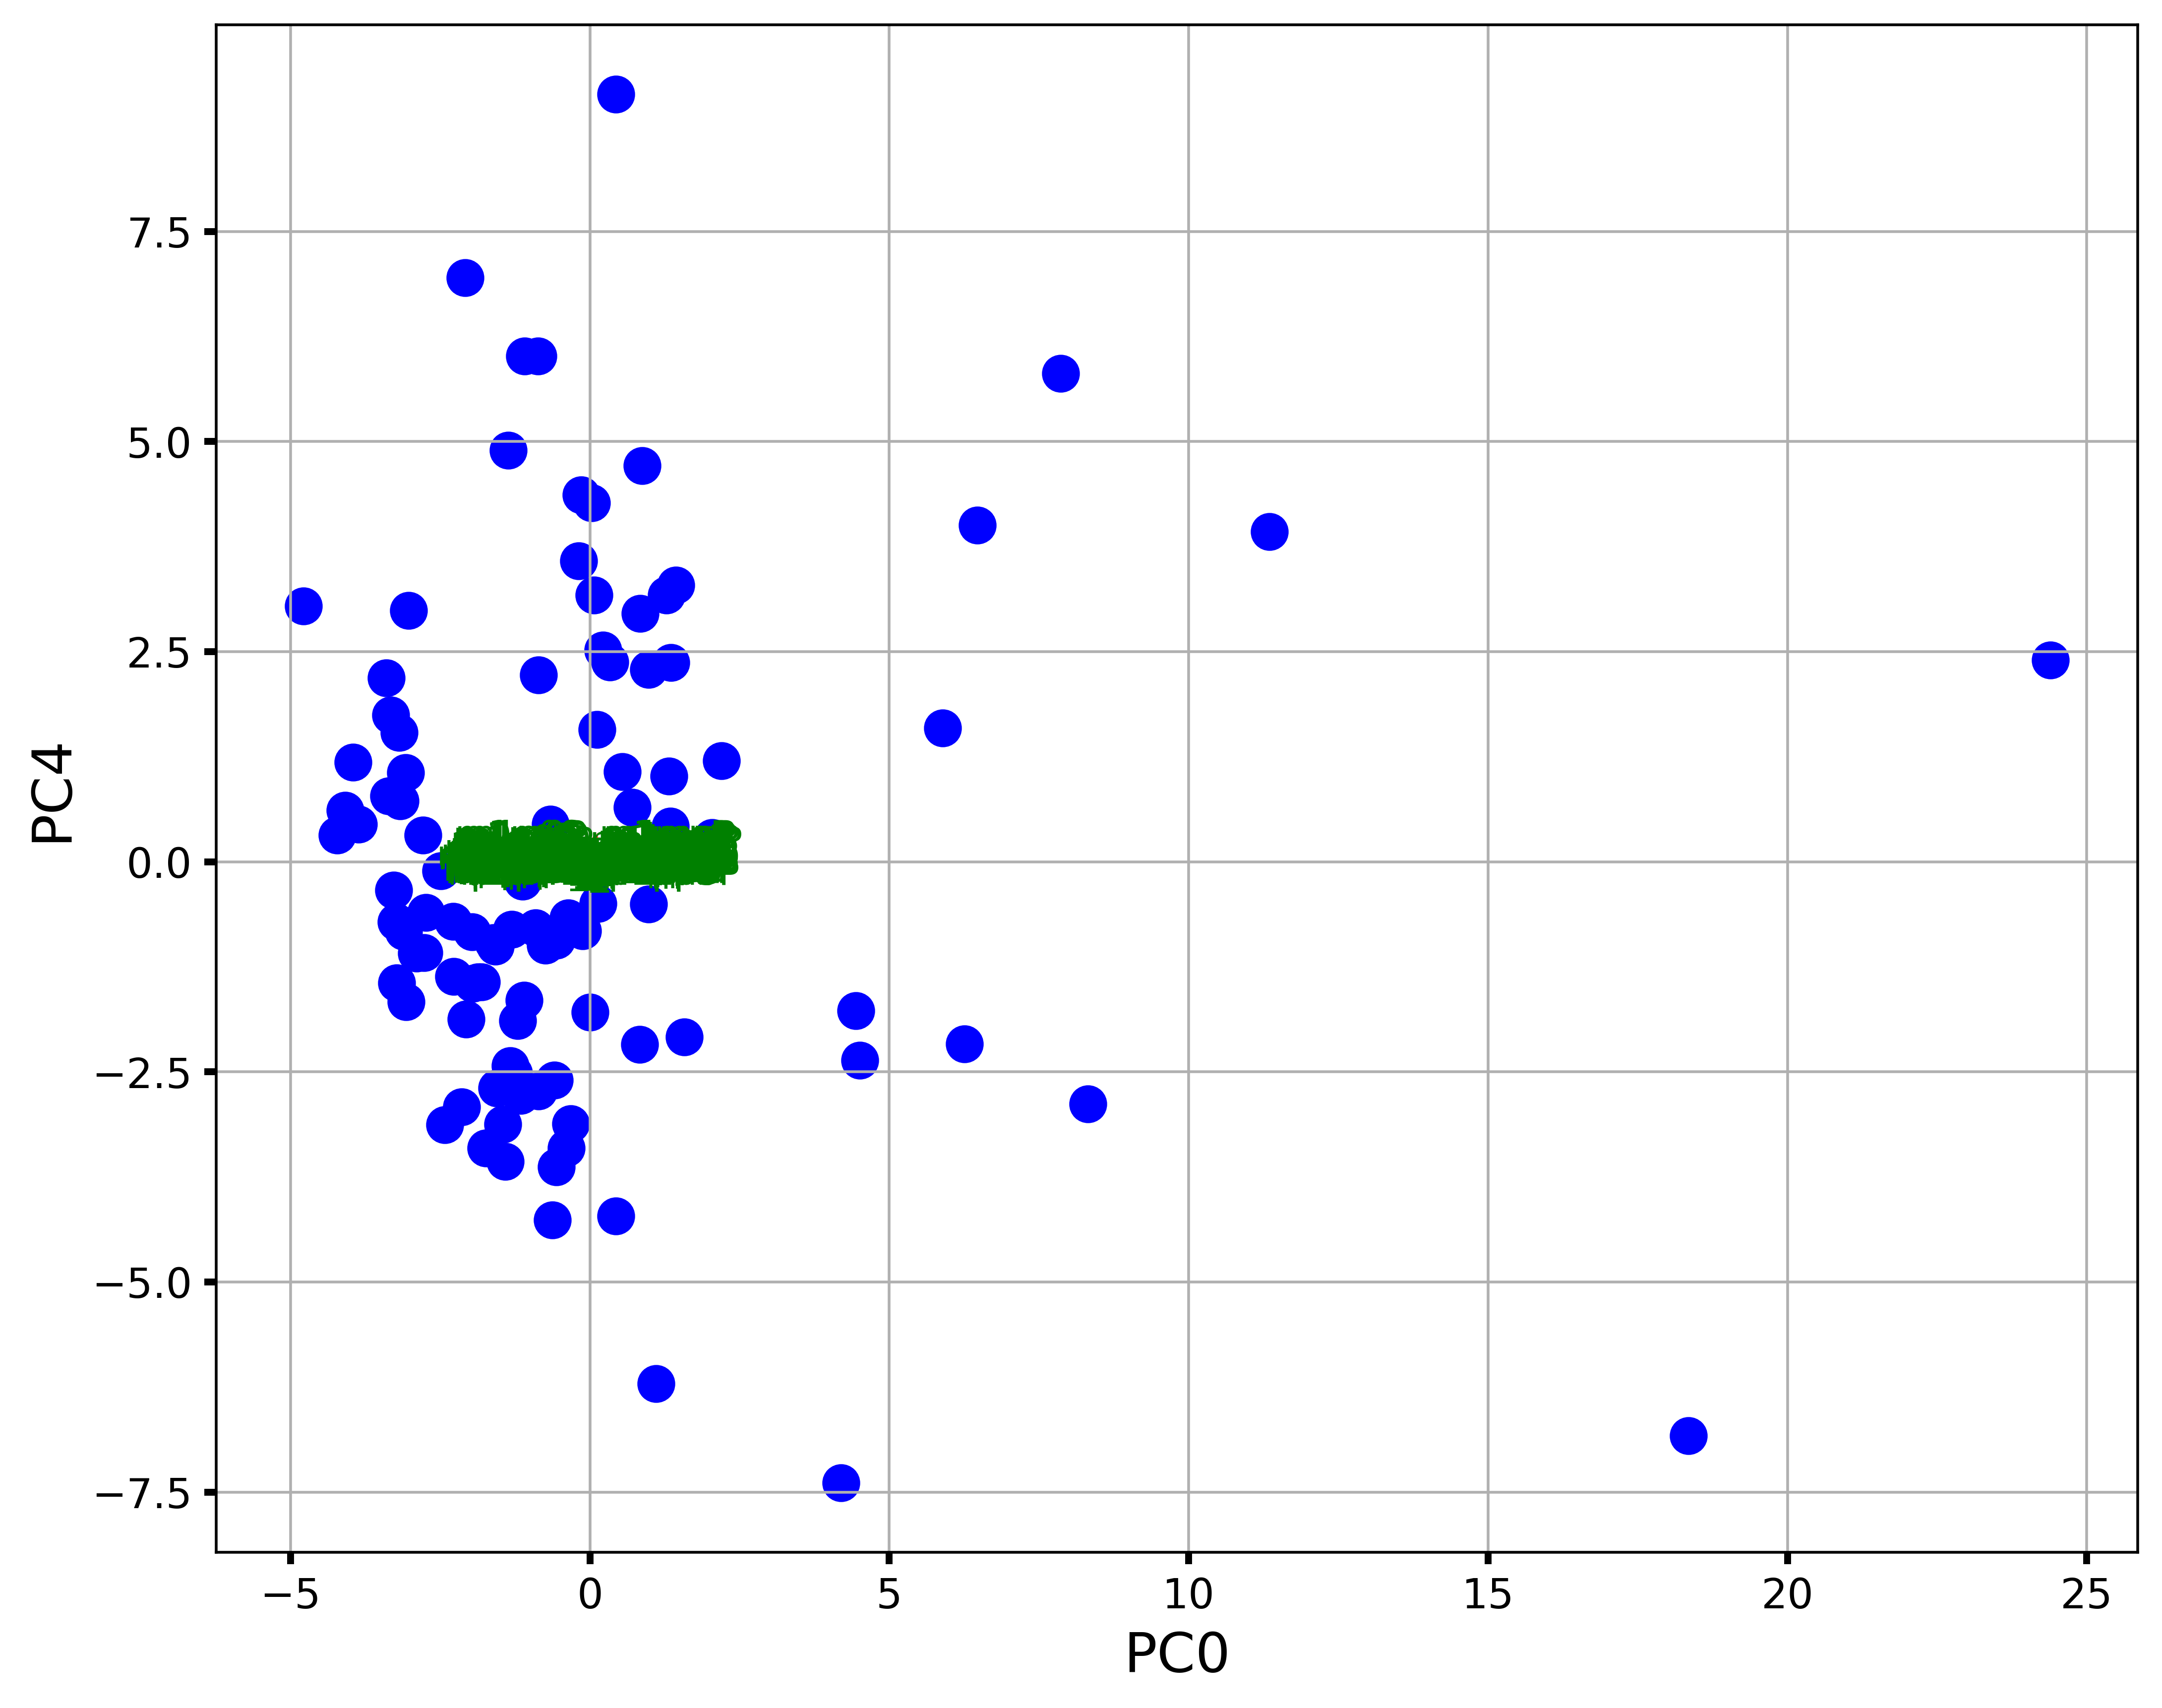

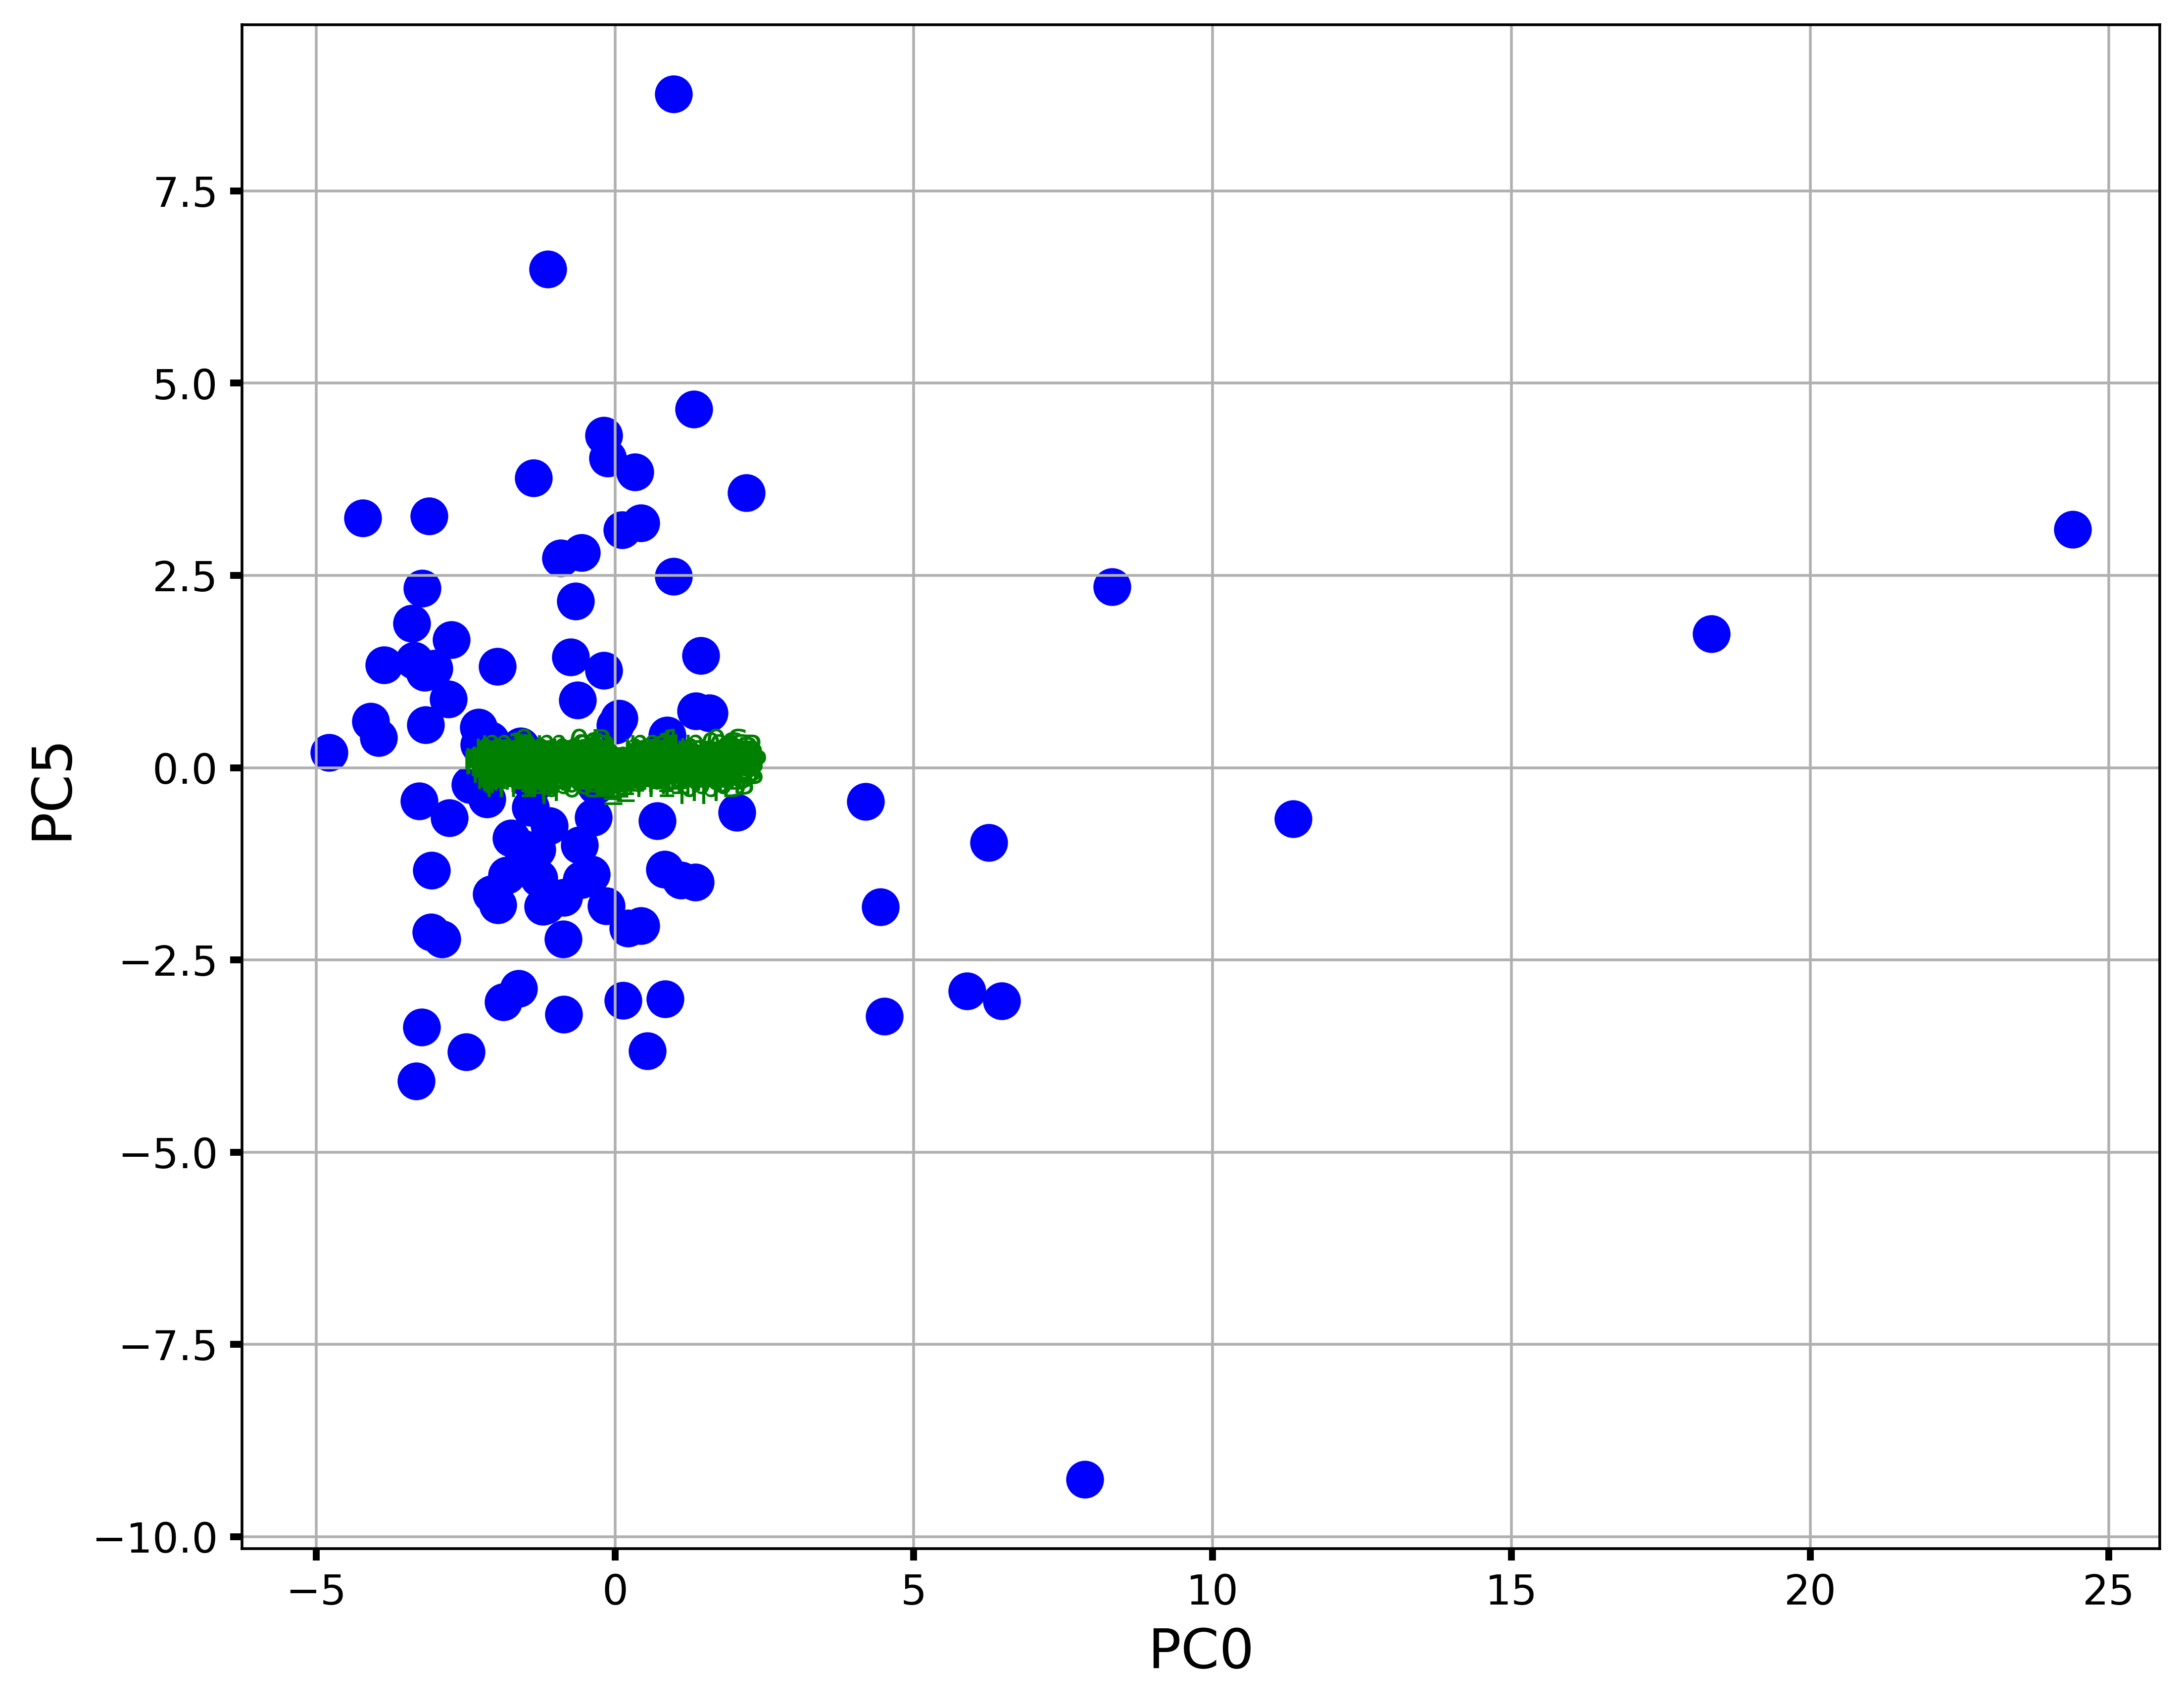

In [9]:
def biplot(principal_components, column, scores, labels):
    xs = principal_components[:,0]
    ys = principal_components[:, column]
    n_components = scores.shape[0]

    plt.scatter(xs, ys, color="blue")
    for i, label in enumerate(labels):
        plt.arrow(0, 0, scores[i, 0], scores[i, column], color="r", alpha=0.5)
        plt.text(scores[i, 0]*1.15, scores[i, column]*1.15, label, color="g", ha="center", va="center")

    plt.xlabel(f"PC0")
    plt.ylabel(f"PC{column}")
    plt.grid()
    plt.show()
    return

labels = features
biplot(principal_components, 1, pca.components_.T, labels)
biplot(principal_components, 2, pca.components_.T, labels)
biplot(principal_components, 3, pca.components_.T, labels)
biplot(principal_components, 4, pca.components_.T, labels)
biplot(principal_components, 5, pca.components_.T, labels)